In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import sys
import json

## Standard VAE + Bedford VAE

In [2]:
abspath = "./VAE_standard"

In [3]:
sys.path.append(abspath)
from models import DNADataset, ALPHABET, SEQ_LENGTH, LATENT_DIM, VAE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE as tsne
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

import bedford_code.models_bedford as bedford

In [4]:
BATCH_SIZE = 64
# "data" directory is generated as shown in README.md file
dataset = DNADataset(f"{abspath}/../data/training_spike.fasta")
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [6]:
input_dim = len(ALPHABET) * SEQ_LENGTH
# input_dim = 29903 * 5
# input_dim = 29903

# BEDFORD
# vae_model = bedford.VAE(input_dim=len(bedford.ALPHABET) * bedford.SEQ_LENGTH, latent_dim=bedford.LATENT_DIM).to(DEVICE)
# vae_model.load_state_dict(torch.load(f"{abspath}/bedford_code/results_bedford/BEST_vae_ce_anneal.pth"))
#STANDARD
vae_model = VAE(input_dim=input_dim, latent_dim=50).to(DEVICE)
vae_model.load_state_dict(torch.load(f"{abspath}/model_saves/standard_VAE_model_BEST.pth", weights_only=True, map_location=DEVICE))


vae_model.eval()

/home/averma2/miniforge3/envs/Moreta_env/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


VAE(
  (non_linear_activation): ReLU()
  (encoder): Encoder(
    (non_linear_activation): ReLU()
    (encode): Sequential(
      (0): Linear(in_features=19110, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=256, bias=True)
      (3): ReLU()
    )
    (fc_mean): Linear(in_features=256, out_features=50, bias=True)
    (fc_logvar): Linear(in_features=256, out_features=50, bias=True)
  )
  (decoder): Decoder(
    (non_linear_activation): ReLU()
    (means): ModuleList(
      (0): Linear(in_features=50, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=512, bias=True)
      (2): Linear(in_features=512, out_features=19110, bias=True)
    )
  )
)

In [7]:
dset = ["training", "valid", "test"]
dset = dset[0]
print(dset)
abspath = "."
dataset = DNADataset(f"{abspath}/data/{dset}_spike.fasta")
new_dataset = np.array([dataset[x][0].numpy() for x in range(len(dataset))])
vals = np.array([dataset[x][1] for x in range(len(dataset))])
# labeling
metadata = pd.read_csv(f"{abspath}/data/all_data/all_metadata.tsv", sep="\t")
clade_labels = [metadata.loc[metadata.name == vals[i], "clade_membership"].values[0] for i in range(len(vals))]

training


In [8]:
good_clade_labels = []
for c in clade_labels:
    if len(metadata[metadata.clade_membership == c]) > 5:
        good_clade_labels.append(c)
print(set(good_clade_labels))

{'24I (MV.1)', '22C (BA.2.12.1)', '25B (NB.1.8.1)', '22F (XBB)', '22D (BA.2.75)', '21L (BA.2)', '24E (KP.3.1.1)', '24A (JN.1)', '24F (XEC)', '23I (BA.2.86)', '23F (EG.5.1)', '19A', '25A (LP.8.1)', '21K (BA.1)', '23D (XBB.1.9)', '23A (XBB.1.5)', '22B (BA.5)', '24D (XDV.1)', '22A (BA.4)', '25C (XFG)', '23B (XBB.1.16)', '24H (LF.7)'}


In [9]:
# print(set(clade_labels))

# clusters = np.sort(np.array(list(set(good_clade_labels))))
clusters = np.sort(np.array(list(set(clade_labels))))
print(clusters)
get_clade = lambda x: [True if elem == x else False for elem in clade_labels]

indexes = tuple([np.arange(len(clade_labels))[get_clade(x)] for x in clusters])

['19A' '21K (BA.1)' '21L (BA.2)' '21M (Omicron)' '22A (BA.4)' '22B (BA.5)'
 '22C (BA.2.12.1)' '22D (BA.2.75)' '22E (BQ.1)' '22F (XBB)'
 '23A (XBB.1.5)' '23B (XBB.1.16)' '23C (CH.1.1)' '23D (XBB.1.9)'
 '23E (XBB.2.3)' '23F (EG.5.1)' '23G (XBB.1.5.70)' '23H (HK.3)'
 '23I (BA.2.86)' '24A (JN.1)' '24D (XDV.1)' '24E (KP.3.1.1)' '24F (XEC)'
 '24G (KP.2.3)' '24H (LF.7)' '24I (MV.1)' '25A (LP.8.1)' '25B (NB.1.8.1)'
 '25C (XFG)']


In [10]:
new_vals = []
for v in vals:
    if metadata.loc[metadata.name == v, "clade_membership"].values[0] in clusters:
        new_vals.append(v)

In [11]:
parents = pd.read_csv(f"{abspath}/data/all_data/all_branches.tsv", sep="\t")
node_dict = {x:i for i,x in enumerate(new_vals)}
pairs = []
for p,c in zip(parents["parent"], parents["child"]):
    i1 = node_dict.get(p, None)
    i2 = node_dict.get(c, None)

    if i1 and i2:
        pairs.append((i1,i2))

pairs = np.array(pairs)

X shape
(6368, 3822, 5)
torch.Size([6368, 3822, 5])

Recon shape
torch.Size([6368, 19110])
[0.45191533 0.33159555 0.19805563]
total variance: 0.9815665069351586


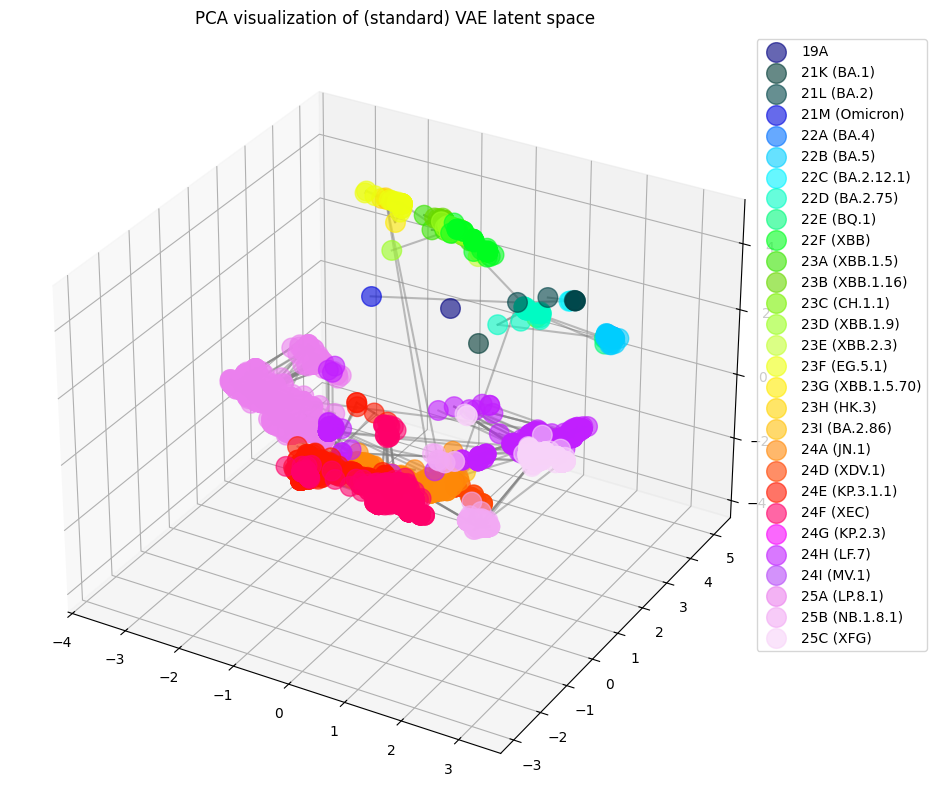

In [45]:
cmap = plt.get_cmap("gist_ncar")
colors = [cmap(x) for x in np.arange(len(indexes)) / len(indexes)]

ranges = np.concatenate(indexes)

X = torch.tensor(new_dataset[ranges,:,:])
print("X shape")
print(new_dataset.shape)
print(X.shape)
# X = X.to(DEVICE)
X = X.view(X.size(0), -1).to(DEVICE)
pca = PCA(n_components=3, svd_solver="full")

fig,ax = plt.subplots(1,1,figsize=(14,10),subplot_kw=dict(projection="3d"))
recon = None
Z_mean = None
Z_embedded = None
with torch.no_grad():
    # STANDARD
    Z_mean, Z_logvar = vae_model.encoder.forward(X)
    recon = vae_model.decoder.forward(Z_mean)
    recon = recon.view(recon.shape[0], -1).cpu()
    Z_mean = Z_mean.cpu()
    Z_std = torch.exp(0.5 * Z_logvar).cpu()

    # BEDFORD
    # recon, Z_mean, Z_logvar = vae_model.forward(X)
    # recon = recon.cpu().numpy()
    # Z_mean = Z_mean.cpu().numpy()
    
    print("\nRecon shape")
    print(recon.shape)
    
    # Z_embedded = tsne(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X = Z_mean)
    pca.fit(Z_mean)
    Z_embedded = pca.transform(Z_mean - torch.mean(Z_mean))
    variances = pca.explained_variance_ratio_
    tot = np.sum(variances)
    print(variances)
    print(f"total variance: {tot}")
    curr = 0
    for i,arr in enumerate(indexes):
        loc_arr = list(range(curr,curr + len(arr),1))
        # print(set([clade_labels[x] for x in ranges[loc_arr]]))
        ax.scatter(Z_embedded[loc_arr,0], Z_embedded[loc_arr,1], Z_embedded[loc_arr, 2], label=clade_labels[arr[0]], alpha=0.6, color=colors[i], s=200)
        curr += len(arr)

    for p in pairs:
        ax.plot(Z_embedded[p,0], Z_embedded[p,1], Z_embedded[p,2], color="gray", alpha=0.5)

l1 = 0.1
l2 = 0
ax.set_title("PCA visualization of (standard) VAE latent space")
ax.legend(bbox_to_anchor=(l1,l2,l1+1,l2+1))
plt.show()

In [43]:
print(pca.components_.shape)
print(pca.singular_values_)

(3, 50)
[136.81514595 117.19524374  90.57309999]


In [85]:
genome = X.view(X.shape[0], -1, len(ALPHABET)).cpu().numpy().astype("int")
genome = np.matmul(genome, np.arange(len(ALPHABET)))

In [91]:
print(.shape)

(6366,)


In [94]:
print(np.linalg.norm(Z_embedded, axis=-1)[0])

4.968075182450365


6368



KeyboardInterrupt



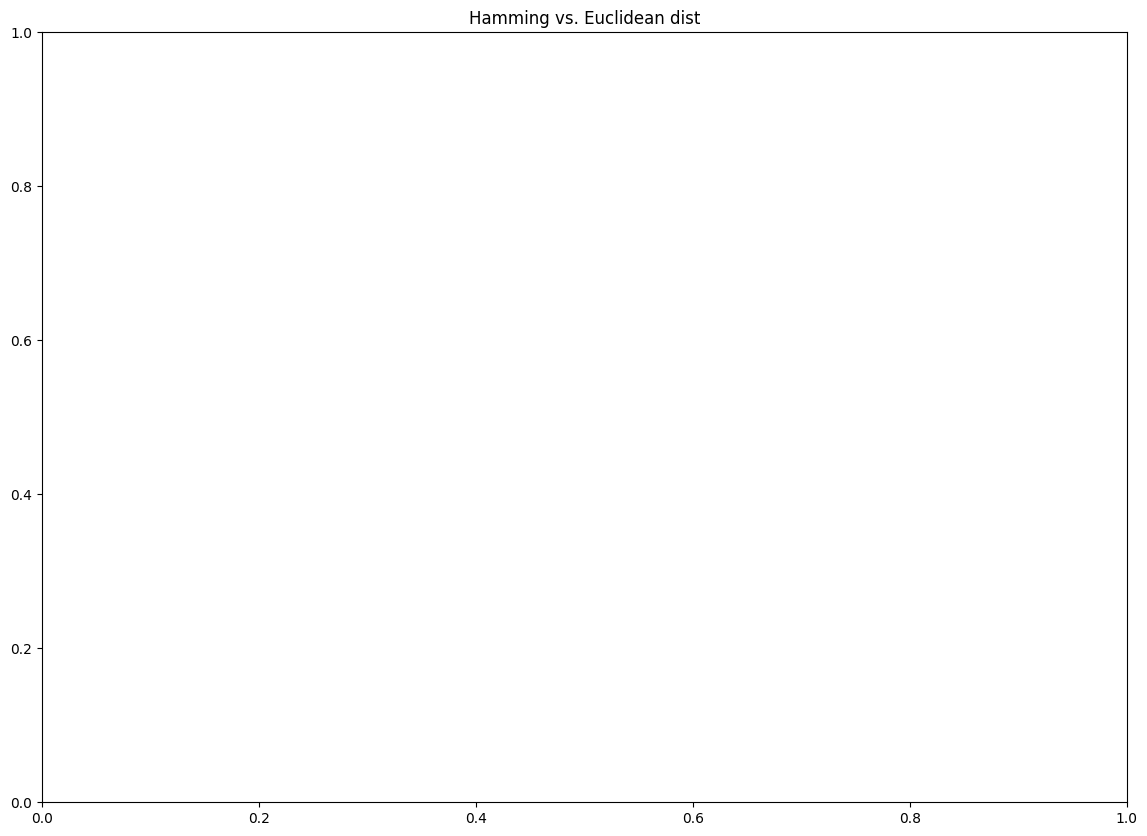

In [115]:
N = Z_embedded.shape[0]
print(N)
hamming = [np.sum(np.not_equal(genome[i,:],genome[(i+1):,:]),axis=-1) for i in range(N-1)]
euclid = [np.linalg.norm((Z_embedded[(i+1):,:] - Z_embedded[i,:]), axis=-1) for i in range(N-1)]

fig,arr = plt.subplots(1,1,figsize=(14,10))
arr.set_title("Hamming vs. Euclidean dist")
arr.scatter(hamming, euclid, alpha=0.3)
plt.show()

In [116]:
print(metadata.columns)

Index(['name', 'parent', 'date', 'clade_membership', 'S1_mutations'], dtype='object')


In [128]:
from treetime.utils import datetime_from_numeric
import pymc3 as pm

ModuleNotFoundError: No module named 'pymc3'

In [125]:
dates = [metadata.loc[metadata.name == vals[i], "date"].values[0] for i in range(len(vals))]
dates = [datetime_from_numeric(x) for x in dates]

In [ ]:
import theano.tensor as tt
x_vals = np.array(range(len(avg_coords_by_quarter))).reshape(-1, 1).astype('float32')

def build_coords_model(coordinate):
    y_vals = avg_coords_by_quarter[coordinate].values.astype('float32')
    
    print(x_vals.shape, y_vals.shape)

    with pm.Model() as model:
        # l = pm.HalfCauchy('l', beta=20)
        l = pm.Uniform('l', 0, 30)

        # Covariance function
        log_s2_f = pm.Uniform('log_s2_f', lower=-10, upper=5)
        s2_f = pm.Deterministic('s2_f', tt.exp(log_s2_f))
        # s2_f = pm.HalfCauchy('s2_f', beta=2)
        # f_cov = s2_f * pm.gp.cov.Matern52(input_dim=1, lengthscales=l)
        f_cov = s2_f * pm.gp.cov.ExpQuad(input_dim=1, lengthscales=l)

        # Sigma
        log_s2_n = pm.Uniform('log_s2_n', lower=-10, upper=5)
        s2_n = pm.Deterministic('s2_n', tt.exp(log_s2_n))
        # s2_n = pm.HalfCauchy('s2_n', beta=2)

        y_obs = pm.gp.GP('y_obs', cov_func=f_cov, sigma=s2_n, 
                         observed={'X':x_vals, 
                                   'Y':y_vals})
        trace = pm.sample(2000)

        pp_x = np.arange(len(avg_coords_by_quarter)+2)[:, None]
        gp_samples = pm.gp.sample_gp(trace=trace, gp=y_obs, X_values=pp_x, samples=1000)

    return gp_samples